# Testing K-means Clustering Algorithm

Interact via IO and various drivers:
* root/run.f90   

In [6]:
"""Set up grid
"""
%load_ext autoreload
%autoreload 2

import numpy as np

# Grid settings
n_x = n_y = 50
limits_x = (0, 10)
limits_y = (0, 10)

# Define a grid of points in 2D space
x = np.linspace(*limits_x, n_x)
y = np.linspace(*limits_y, n_y)
X, Y = np.meshgrid(x, y)

# Grid to define Gaussians
grid = np.dstack((X, Y))
assert grid.shape == (n_x, n_y, 2), 'Nx, Ny, Ndim'

# Reshape for format expected by kmeans algorithm
# i.e. grid[1, 0, :] == grid_reshaped[40, :]
flat_grid = grid.reshape(-1, 2)
assert flat_grid.shape == (n_x * n_y, 2), 'Npoints, Ndim'

# print(flat_grid.shape)
# for p in flat_grid:
#     print(p)

# Write grid settings for parsing by fortran program
with open("grid_settings.dat", "w") as fid:
    fid.write("# start   stop   n_points \n")
    string = " ".join(str(s) for s in limits_x) + " " + str(n_x) + "\n"
    fid.write(string)
    string = " ".join(str(s) for s in limits_y) + " " + str(n_y) + "\n"
    fid.write(string)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


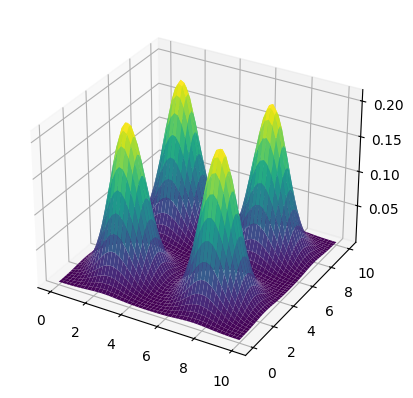

In [7]:
"""Set up Gaussians on grid
"""
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Place a Gaussian distribution in each quadrant of the cubic grid
mu1 = [2.5, 2.5]
mu2 = [7.5, 2.5]
mu3 = [2.5, 7.5]
mu4 = [7.5, 7.5]
cov = [[0.75, 0], [0, 0.75]]  # Covariance matrix: Diagonals are variances == std^2 i.e. (Gaussian width)^2

z1 = multivariate_normal.pdf(grid, mean=mu1, cov=cov)
z2 = multivariate_normal.pdf(grid, mean=mu2, cov=cov)
z3 = multivariate_normal.pdf(grid, mean=mu3, cov=cov)
z4 = multivariate_normal.pdf(grid, mean=mu4, cov=cov)
z_total = z1 + z2 + z3 + z4

visualise_gaussians_in_3d = True

if visualise_gaussians_in_3d:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, z_total, cmap='viridis')
    plt.show()

# Output total gaussian for parsing by fortran
np.savetxt("weights.dat", z_total.reshape(-1))



In [8]:
"""Output initial centroids
"""
import subprocess

n_iterpolation_points = 25
nr = flat_grid.shape[0]

# Fix the random seed
np.random.seed(42)
random_indices = np.sort(np.random.choice(nr, size=n_iterpolation_points, replace=False))

initial_centroids = flat_grid[random_indices, :]
np.savetxt("init_centroids.dat", initial_centroids, header=f'{n_iterpolation_points}', comments='')

# Run fortran code
try:
    result = subprocess.run(['../cmake-build-debug/run_kmeans'], check=True)
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")

# Parse in final centroids
final_centroids = np.loadtxt("final_centroids.dat", skiprows=1)


 Iteration            1
 # Current Point  ,  Prior Point  ,  |ri - r_{i-1}|  ,  tol
    7.7443748582     0.4422972105     9.3877551020     0.6122448980     1.6433802438     0.1699476874     0.0000010000
    7.6907278094     1.3039013560     9.3877551020     0.8163265306     1.6970272926     0.4875748254     0.0000010000
    1.5312910644     1.9393968685     0.4081632653     1.6326530612     1.1231277991     0.3067438073     0.0000010000
    4.8827577291     1.5029164538     4.2857142857     1.8367346939     0.5970434434     0.3338182401     0.0000010000
    8.1664807091     2.4134197096     9.5918367347     1.8367346939     1.4253560256     0.5766850157     0.0000010000
    2.8079490851     2.2643124782     3.6734693878     2.6530612245     0.8655203027     0.3887487463     0.0000010000
    4.1621288230     2.5340273940     4.0816326531     2.6530612245     0.0804961700     0.1190338305     0.0000010000
    3.9077963453     3.1313297050     3.8775510204     2.8571428571     0.030245324

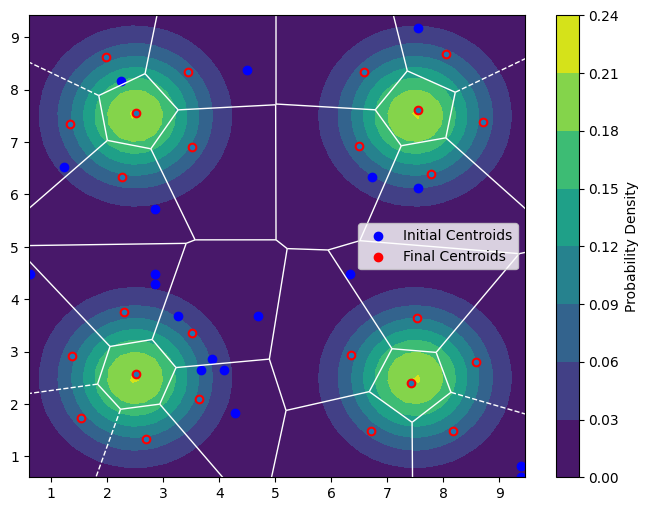

In [9]:
"""_summary_
"""
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Gaussians (weight)
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, z_total, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Probability Density')

# Centroids
ax.scatter(initial_centroids[:, 0], initial_centroids[:, 1], color='blue', label='Initial Centroids')
ax.scatter(final_centroids[:, 0], final_centroids[:, 1], color='red', label='Final Centroids')

# Voronoi diagram
vor = Voronoi(final_centroids)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors="white")
ax.legend()
plt.show()